# Recognizing MNIST Digits

<a href="https://colab.research.google.com/github/DeepTrackAI/DeepTrack2/blob/develop/tutorials/2-examples/DTEx201_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install deeplay deeptrack  # Uncomment if running on Colab/Kaggle.

This example trains a fully connected neural network to identify handwritten digits using MNIST dataset.

In [2]:
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import torch

## 1. Downloading the MNIST Dataset

Start by downloading the MNIST dataset.

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

You will download it from the GitHub repository https://github.com/DeepTrackAI/MNIST_dataset, where the MNIST images are organized in two folders named `train` and `test`:

> train/0_000000.png<br>
> train/0_000001.png<br>
> ...<br>
> train/1_000000.png<br>
> ...<br>

> test/0_000000.png<br>
> ...<br>
> test/1_000000.png<br>
> ...<br>

The first digit in the filename is the label.

In [3]:
import os

if not os.path.isdir("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

train_path = os.path.join("MNIST_dataset", "mnist", "train")
test_path = os.path.join("MNIST_dataset", "mnist", "test")

## 2. Loading the Training Dataset

The dataset is how you provide the network with training data. For this example, you will create the dataset by loading it from storage using the `LoadImage` class.

You start by creating an `ImageFolder` object to hold the list of files corresponding to the training images.

In [4]:
train_files = dt.sources.ImageFolder(train_path)

print(f"Dataset contains {len(train_files)} train images")

Dataset contains 60000 train images


Then, you create a pipeline that loads the normalized images and another one that loads the corresponding digit.

In [5]:
# Pipeline to load the images.
train_image = (
    dt.LoadImage(path=train_files.path)
    >> dt.NormalizeMinMax(0, 1)  # Normalize the image to [0, 1].
    >> dt.MoveAxis(2, 0)  # Move the color channel to the first axis.
    >> dt.pytorch.ToTensor(dtype=torch.float32) # Convert to a PyTorch tensor.
)

# Pipeline to load the labels.
train_digit = (
    dt.Value(train_files.label_name[0])  # Get the first digit of the name.
    >> int  # Convert the digit to an integer.
    >> np.array  # Convert to a NumPy array.
    >> dt.pytorch.ToTensor(dtype=torch.long)  # Convert to a PyTorch tensor.
)

Finally, you cobine them into a single dataset that returns a tuple with a MNIST image and the corresponding ground-truth digit value.

In [6]:
train_dataset = dt.pytorch.Dataset(
    train_image & train_digit,
    train_files,
)

You can now plot some example images.

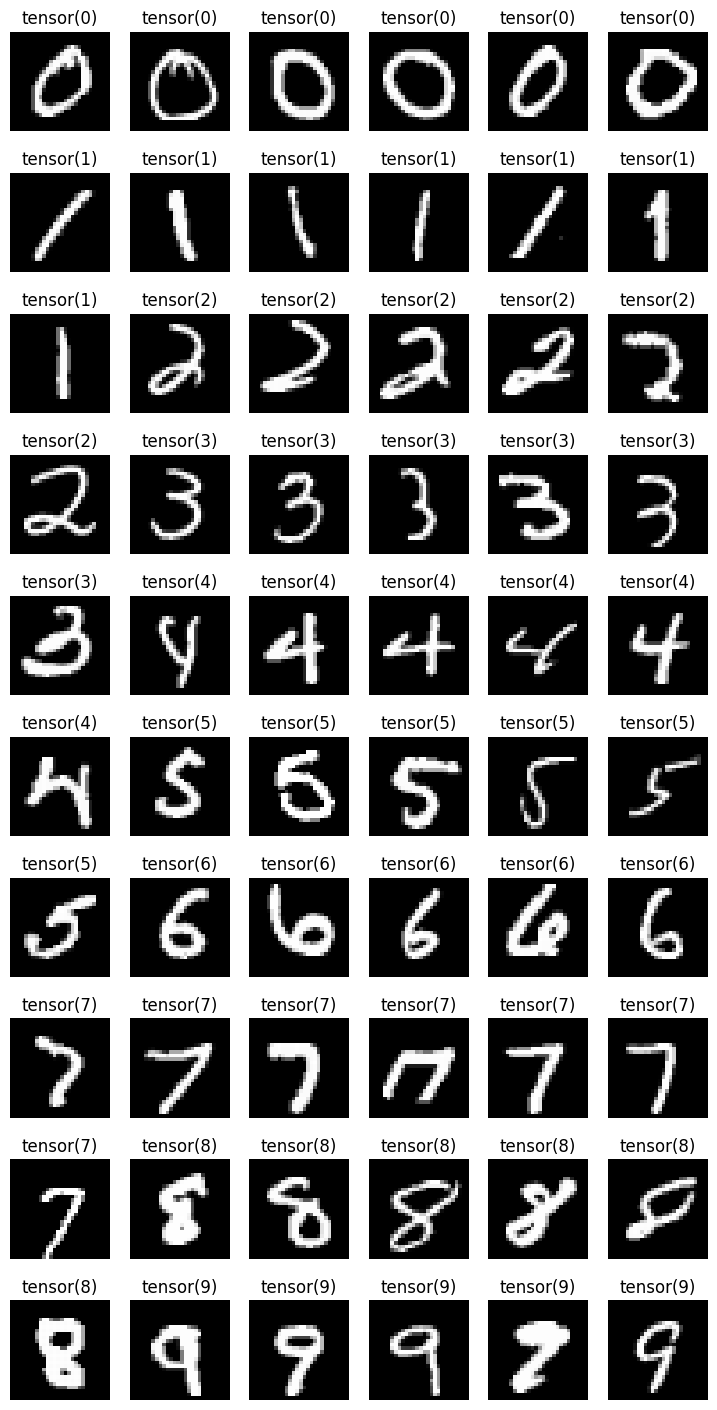

In [7]:
fig, axs = plt.subplots(10, 6, figsize=(9, 18))

for i, ax in enumerate(axs.flatten()):
    image, digit = train_dataset[i * 1_000]
    ax.imshow(image.numpy().squeeze(), cmap="gray")
    ax.set_title(digit)
    ax.axis("off")

### 1.1. Loading the Validation Dataset

You follow similar steps to load the validation dataset.

In [8]:
test_files = dt.sources.ImageFolder(test_path)

print(f"Dataset contains {len(test_files)} test images")

test_image = (
    dt.LoadImage(path=test_files.path)
    >> dt.NormalizeMinMax(0, 1)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)
test_digit = (
    dt.Value(test_files.label_name[0])
    >> int
    >> np.array
    >> dt.pytorch.ToTensor(dtype=torch.long)
)

test_dataset = dt.pytorch.Dataset(test_image & test_digit, test_files)

Dataset contains 10000 test images


## 2. Augmenting the Training Set

In order to expand the dataset, you will augment it with affine and elastic augmentations.

Affine augmentations consist of translating, rescaling, rotating and shearing.

In [9]:
# How much to scale in x and y.
scale = {
    "x": lambda: 0.8 + np.random.rand() * 0.4,
    "y": lambda: 0.8 + np.random.rand() * 0.4,
}

# How much to translate in x and y.
translate_px = {
    "x": lambda: int(np.random.randint(-2, 3)),
    "y": lambda: int(np.random.randint(-2, 3)),
}

# Dummy property: whether to rotate or shear.
should_rotate = lambda: np.random.randint(2)

# If should rotate, how much.
rotate = lambda should_rotate: (-0.35 + np.random.rand() * 0.7) * should_rotate

# If not should rotate, how much shear.
shear = lambda should_rotate: (
    (-0.35 + np.random.rand() * 0.7) * (1 - should_rotate)
)

affine_transform = dt.Affine(
    scale=scale,
    translate_px=translate_px,
    should_rotate=should_rotate,
    shear=shear,   
    order=2,
    mode="constant",
)

Elastic augmentations distort the image elastically.

In [10]:
# Amplitude of distortions.
alpha = lambda: np.random.rand() * 60

# Granularity of distortions.
sigma = lambda: 5 + np.random.rand() * 2

# Last dimension is not a channel, so it should be augmented too.
ignore_last_dim = True

elastic_transform = dt.ElasticTransformation(
    alpha=alpha,
    sigma=sigma,
    ignore_last_dim=ignore_last_dim,
    mode="constant",
)

Finally, since these distortions may cause pixels to fall outside the range of (0, 1), you need to clip the values.

In [11]:
clip = dt.Clip(0, 1)

You can now add the augmentations to the pipeline.

By setting `replace=True`, you ensure that the images of the digits are replaced in each epoch of the training. You can set `replace=.1` (or another number between 0 and 1) to achieve a tradeoff between diversity of the training set and computational speed.

In [12]:
augmentation = affine_transform >> elastic_transform >> clip

augmented_train_image = (
    dt.LoadImage(path=train_files.path)
    >> dt.NormalizeMinMax(0, 1)
    >> augmentation  # Apply the augmentation.
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

augmented_train_dataset = dt.pytorch.Dataset(
    augmented_train_image & train_digit,
    train_files,
    replace=True, 
)

To ensure the data and the labels match up, plot some images and print their corresponding label.

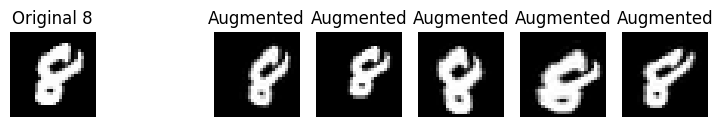

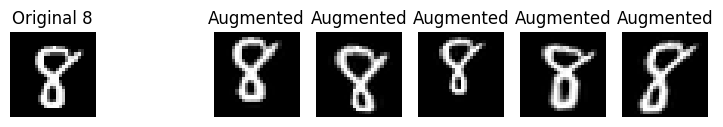

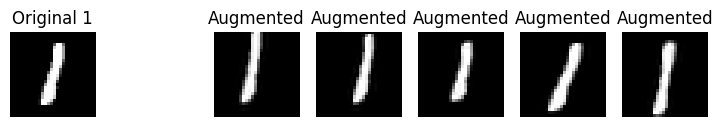

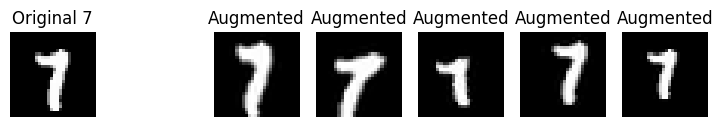

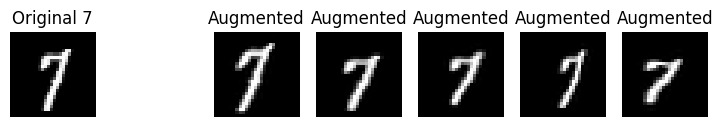

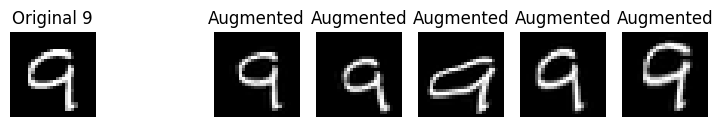

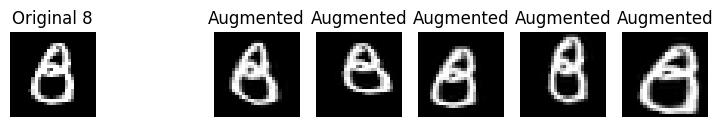

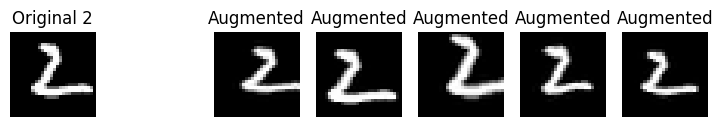

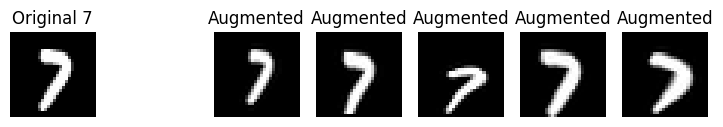

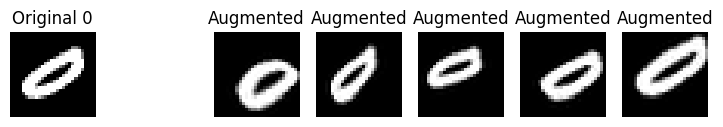

In [13]:
for _ in range(10):
    plt.figure(figsize=(9, 2))
    
    # Select the index of the image to augment.
    i = np.random.randint(len(train_files))

    # Get the original image and digit.
    original_image, digit = train_dataset[i]

    plt.subplot(1, 7, 1)
    plt.imshow(original_image.numpy().squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"Original {digit}")


    for sub_plt in range(3, 8):

        # Get the augmented image.
        augmentation.update()
        augmented_image, _ = augmented_train_dataset[i]

        plt.subplot(1, 7, sub_plt)
        plt.imshow(augmented_image.numpy().squeeze(), cmap="gray")
        plt.axis("off")
        plt.title("Augmented")

    plt.show()

## 3. Defining the Network

The network used is a fully connected neural network.

First, you define the network architecture.

In [14]:
import deeptrack.deeplay as dl

mlp_template = dl.MultiLayerPerceptron(
    in_features=28 * 28,
    hidden_features=[128, 128, 64, 64],
    out_features=10,
)
for block in mlp_template.blocks:
    block.append(dl.Layer(torch.nn.Dropout, 0.1))
mlp_template[..., "activation#-1"].configure(torch.nn.Softmax, dim=-1)
mlp = mlp_template.create()

print(mlp)

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LinearBlock(
      (layer): Linear(in_features=784, out_features=128, bias=True)
      (activation): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): LinearBlock(
      (layer): Linear(in_features=128, out_features=128, bias=True)
      (activation): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): LinearBlock(
      (layer): Linear(in_features=128, out_features=64, bias=True)
      (activation): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (3): LinearBlock(
      (layer): Linear(in_features=64, out_features=64, bias=True)
      (activation): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (4): LinearBlock(
      (layer): Linear(in_features=64, out_features=10, bias=True)
      (activation): Softmax(dim=-1)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)


Then, you compile the network, defining the loss function and the optimizer.

In [15]:
classifier_template = dl.Classifier(
    model=mlp,
    num_classes=10,
    make_targets_one_hot=True,
    optimizer=dl.RMSprop(lr=0.001)
)
classifier = classifier_template.create()
    
print(classifier)

Classifier(
  (loss): CrossEntropyLoss()
  (optimizer): RMSprop[RMSprop](lr=0.001)
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Linear(in_features=784, out_features=128, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): LinearBlock(
        (layer): Linear(in_features=128, out_features=128, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (2): LinearBlock(
        (layer): Linear(in_features=128, out_features=64, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (3

## 4. Training the Network

You can now train the network. First define the data loaders for the training and validation data.

In [16]:
train_dataloader = torch.utils.data.DataLoader(
    augmented_train_dataset,
    batch_size=32,
    shuffle=True,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
)

Finally, you can proceed with the training.

The training process can be quite slow (several hour on GPU) because the augmented images are used only once during the training. You can speed it up by reducing the numebr of epochs (for example, to 10) and decreasing the `replace` parameter in the dataset (for example, to .1 or 0).

In [17]:
trainer = dl.Trainer(
    max_epochs=100,
    accelerator="auto",
)

trainer.fit(
    classifier, 
    train_dataloader,
    test_dataloader,
)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ CrossEntropyLoss     │      0 │
│ 1 │ train_metrics │ MetricCollection     │      0 │
│ 2 │ val_metrics   │ MetricCollection     │      0 │
│ 3 │ test_metrics  │ MetricCollection     │      0 │
│ 4 │ model         │ MultiLayerPerceptron │  130 K │
│ 5 │ optimizer     │ RMSprop              │      0 │
└───┴───────────────┴──────────────────────┴────────┘

Trainable params: 130 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 130 K                                                                                                
Total estimated model params size (MB): 0

Output()

C:\Users\xgrmir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages
\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not 
have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 
`num_workers=19` in the `DataLoader` to improve performance.

C:\Users\xgrmir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages
\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does 
not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 
`num_workers=19` in the `DataLoader` to improve performance.

You can plot the history of the losses and metrics during the training process.

UnboundLocalError: cannot access local variable 'step' where it is not associated with a value

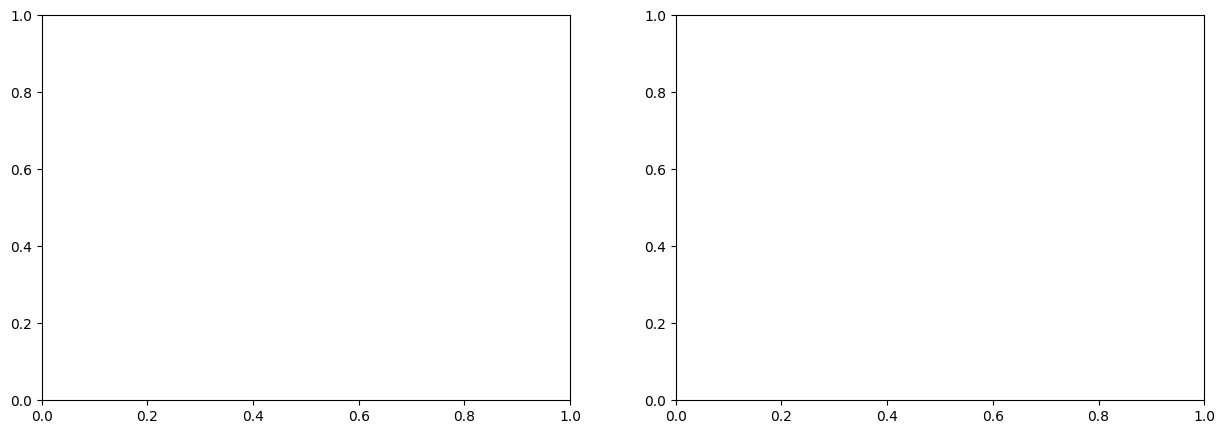

In [18]:
fig, axes = trainer.history.plot()
axes[1].set_yscale("linear")
axes[1].set_ylim(0.0, 1.0)

## 5. Evaluating the Training

You can now proceed to evaluate the quality of the training. To do so, you need first to switch the `classifier` to evaluation mode (for example, to switch off the dropout layers).

In [19]:
classifier.eval();

### 5.1. Comparing Ground-truth and Predicted Digits

You can show a few images wirth the corresponding the true digit and the predicted digit.

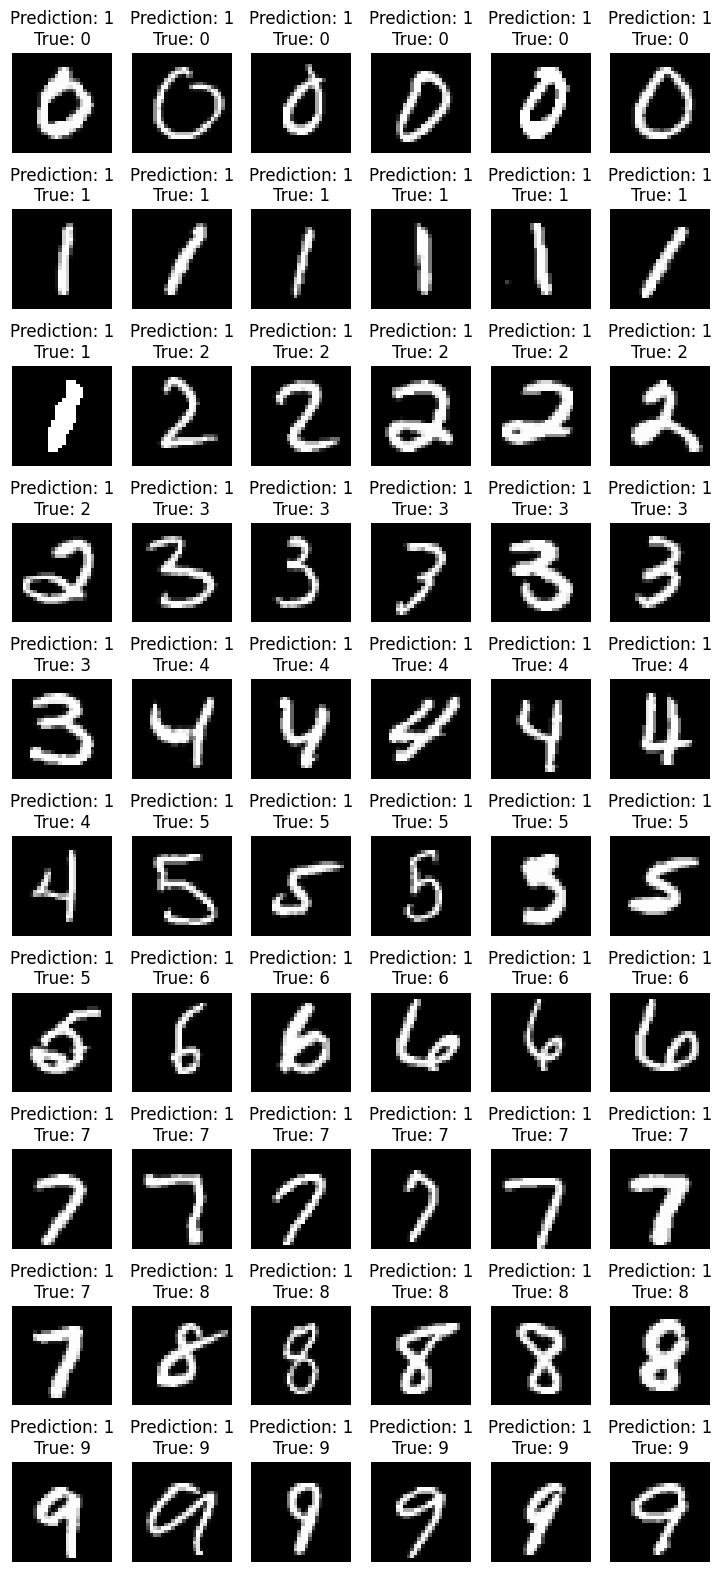

In [20]:
fig, axs = plt.subplots(10, 6, figsize=(9, 20))

for ax, (image, digit) in zip(axs.flatten(), test_dataset[::167]):
    prediction_vector = classifier(image.unsqueeze(0))
    prediction = prediction_vector.argmax().item()

    ax.imshow(image.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Prediction: {prediction}\nTrue: {digit.item()}")
    ax.axis("off")

### 5.2. Calculating the Accuracy

You can calculate the accuracy and error rate on the validation images.

In [21]:
gt_digits = np.array([digit.numpy() for _, digit in test_dataset])
predicted_digits = np.array([classifier(image.unsqueeze(0)).argmax().item()
                             for image, _digit in test_dataset])

accuracy = np.mean(gt_digits == predicted_digits)
print("Accuracy:", accuracy)
print("Error rate:", 1 - accuracy)

KeyboardInterrupt: 

### 5.3 Visualizing Errors

You can make a failure analysis by visualizing a few images that the model predicted incorrectly.

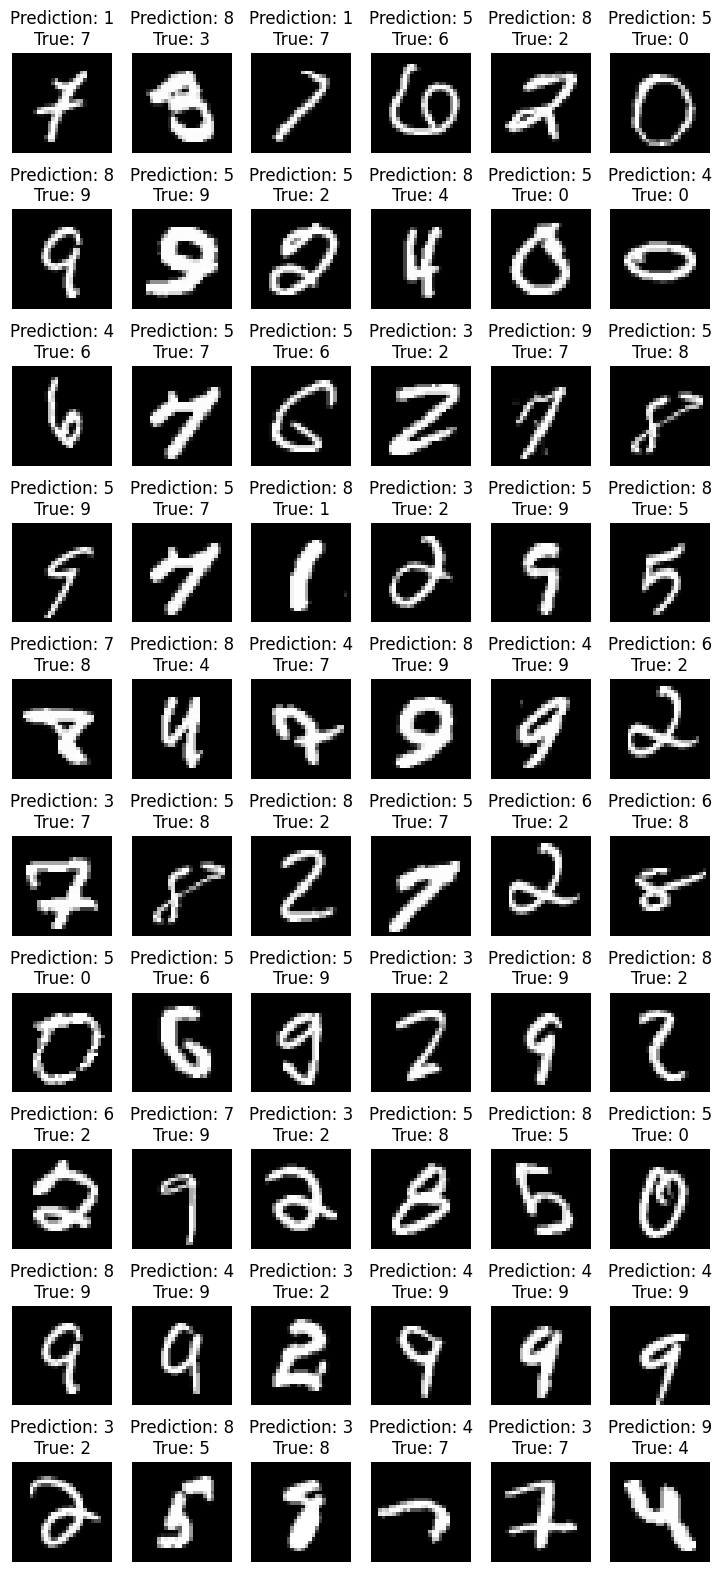

In [22]:
model_is_wrong = predicted_digits != gt_digits
wrong_indices = np.where(model_is_wrong)[0]

fig, axs = plt.subplots(10, 6, figsize=(9, 20))

for ax in axs.flatten():
    i = wrong_indices[np.random.randint(len(wrong_indices))]
    image, digit = test_dataset[i]
    prediction = classifier(image.unsqueeze(0)).argmax().item()
    ax.imshow(image.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Prediction: {prediction}\nTrue: {digit.item()}")
    ax.axis("off")
